In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 78)

In [2]:
test_file = './datasets/test.csv'
train_file = './datasets/train.csv'
spray_file = './datasets/spray.csv'
weather_file = './datasets/weather.csv'

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
spray_df = pd.read_csv(spray_file)
weather_df = pd.read_csv(weather_file)

In [3]:
# Convert Date column to datetime and set as index
train_df['Date'] = pd.to_datetime(train_df['Date'], yearfirst=True)
train_df.set_index('Date', inplace=True)

# Do the same for test set
test_df['Date'] = pd.to_datetime(test_df['Date'], yearfirst=True)
test_df.set_index('Date', inplace=True)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Address                 10506 non-null  object 
 1   Species                 10506 non-null  object 
 2   Block                   10506 non-null  int64  
 3   Street                  10506 non-null  object 
 4   Trap                    10506 non-null  object 
 5   AddressNumberAndStreet  10506 non-null  object 
 6   Latitude                10506 non-null  float64
 7   Longitude               10506 non-null  float64
 8   AddressAccuracy         10506 non-null  int64  
 9   NumMosquitos            10506 non-null  int64  
 10  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 984.9+ KB


In [4]:
# Check for the Trap with more than 1 geolocation 
for trap in train_df['Trap'].unique():
    print(f"Trap {trap}: {len(train_df[train_df['Trap']==trap][['Latitude','Longitude']].drop_duplicates())}")
    
    
# Trap T009: 2 locations
# Trap T035: 2 locations

# New question: Was it intended to change the location of these two traps? Likely i think. 
# Rename these two traps with a suffix to indicate a change of location

Trap T002: 1
Trap T007: 1
Trap T015: 1
Trap T045: 1
Trap T046: 1
Trap T048: 1
Trap T049: 1
Trap T050: 1
Trap T054: 1
Trap T086: 1
Trap T091: 1
Trap T094: 1
Trap T096: 1
Trap T129: 1
Trap T143: 1
Trap T148: 1
Trap T153: 1
Trap T159: 1
Trap T009: 2
Trap T011: 1
Trap T016: 1
Trap T019: 1
Trap T025: 1
Trap T028: 1
Trap T031: 1
Trap T033: 1
Trap T089: 1
Trap T090: 1
Trap T092: 1
Trap T135: 1
Trap T141: 1
Trap T142: 1
Trap T145: 1
Trap T146: 1
Trap T147: 1
Trap T149: 1
Trap T150: 1
Trap T151: 1
Trap T152: 1
Trap T154: 1
Trap T158: 1
Trap T162: 1
Trap T218: 1
Trap T220: 1
Trap T001: 1
Trap T003: 1
Trap T006: 1
Trap T008: 1
Trap T012: 1
Trap T034: 1
Trap T037: 1
Trap T040: 1
Trap T043: 1
Trap T047: 1
Trap T051: 1
Trap T085: 1
Trap T088: 1
Trap T161: 1
Trap T219: 1
Trap T013: 1
Trap T014: 1
Trap T018: 1
Trap T030: 1
Trap T084: 1
Trap T144: 1
Trap T160: 1
Trap T005: 1
Trap T017: 1
Trap T044: 1
Trap T095: 1
Trap T004: 1
Trap T035: 2
Trap T036: 1
Trap T039: 1
Trap T060: 1
Trap T061: 1
Trap T062: 1

In [5]:
# Example: two different locations for Trap T009
train_df[train_df['Trap']=='T035'][['Latitude','Longitude']].drop_duplicates()

,Latitude,Longitude
Date,,
2007-07-11,41.836644,-87.677737
2011-06-17,41.763733,-87.742302


In [6]:
# Rename Trap T009 with a new suffix __2 to indicate a change of location
train_df.loc[(train_df['Trap']=='T009') & (train_df['Latitude']==41.992478) & (train_df['Longitude']==-87.862995),'Trap']='T009__2'

# Rename Trap T035 with a new suffix __2 to indicate a change of location
train_df.loc[(train_df['Trap']=='T035') & (train_df['Latitude']==41.763733) & (train_df['Longitude']==-87.742302),'Trap']='T035__2'

In [7]:
# Number of unique Traps is now 138 matching number of unique geolocations
train_df['Trap'].nunique()

138

In [8]:
# Transform the Test set to update the Trap T009 for the new location suffix __2 likewise
test_df.loc[(test_df['Trap']=='T009') & (test_df['Latitude']==41.992478) & (test_df['Longitude']==-87.862995),'Trap']='T009__2'

# Transform the Test set to update the Trap T035 for the new location suffix __2 likewise
test_df.loc[(test_df['Trap']=='T035') & (test_df['Latitude']==41.763733) & (test_df['Longitude']==-87.742302),'Trap']='T035__2'

In [9]:
test_df['Trap'].nunique()  

# There are 151 Traps in test set, means some of the Trap data won't be captured in train set! Need to somehow capture this
# By geolocation clustering and features associated with each geo-cluster, we can ignore the Trap id as a feature (don't bother target-encoding Trap)


151

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Address                 10506 non-null  object 
 1   Species                 10506 non-null  object 
 2   Block                   10506 non-null  int64  
 3   Street                  10506 non-null  object 
 4   Trap                    10506 non-null  object 
 5   AddressNumberAndStreet  10506 non-null  object 
 6   Latitude                10506 non-null  float64
 7   Longitude               10506 non-null  float64
 8   AddressAccuracy         10506 non-null  int64  
 9   NumMosquitos            10506 non-null  int64  
 10  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 984.9+ KB


In [11]:
# Create new cols for Month and Year index
train_df['month'] = train_df.index.month
train_df['year'] = train_df.index.year
train_df['week'] = train_df.index.week


# Do the same for test set
test_df['month'] = test_df.index.month
test_df['year'] = test_df.index.year
test_df['week'] = test_df.index.week

C:\Users\leagu\AppData\Local\Temp\ipykernel_22148\3599355915.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_df['week'] = train_df.index.week
C:\Users\leagu\AppData\Local\Temp\ipykernel_22148\3599355915.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  test_df['week'] = test_df.index.week


In [12]:
# Define a function to create a col for YearWeek

def year_week(row):
    week = row['week']
    year = row['year']
    row['YearWeek'] = f'{year}{week}'
    row['YearWeek'] = int(row['YearWeek'])
    return row

In [13]:
# Create new col for YearWeek 

train_df = train_df.apply(year_week, axis=1)
test_df = test_df.apply(year_week, axis=1)

In [14]:
train_df.head()

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,month,year,week,YearWeek
Date,,,,,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,2007,22,200722
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,2007,22,200722
2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,5,2007,22,200722
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,5,2007,22,200722
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,5,2007,22,200722


In [15]:
# OneHot encode Species column

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_df[['Species']]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(test_df[['Species']]))

# Rename OH_cols columns 
feature_names = OH_encoder.get_feature_names_out(['Species'])
OH_cols_train.columns = feature_names
OH_cols_test.columns = feature_names

# Put back index to OH_cols df
OH_cols_train.index = train_df.index
OH_cols_test.index = test_df.index

# Add OH encoded columns to original df
train_df = pd.concat([train_df, OH_cols_train], axis=1)
test_df = pd.concat([test_df, OH_cols_test], axis=1)

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Address                         10506 non-null  object 
 1   Species                         10506 non-null  object 
 2   Block                           10506 non-null  int64  
 3   Street                          10506 non-null  object 
 4   Trap                            10506 non-null  object 
 5   AddressNumberAndStreet          10506 non-null  object 
 6   Latitude                        10506 non-null  float64
 7   Longitude                       10506 non-null  float64
 8   AddressAccuracy                 10506 non-null  int64  
 9   NumMosquitos                    10506 non-null  int64  
 10  WnvPresent                      10506 non-null  int64  
 11  month                           10506 non-null  int64  
 12  year           

# Clustering NumMosquitos

This section explores whether the Number of Mosquitos can be clearly segregated into clusters where each cluster has a distinct range of NumMosquitos. KMeans clustering algorithm is first fitted on the train set before it is used to transform the test set. Through this process, we found that there are three distinct clusters of NumMosquitos (k=3) each with different average Number of Mosquitos. 

|cluster|Average NumMosquitos|
|---|---|
|1|5.38|
|2|11.81|
|3|44.26|

In [17]:
X_train = train_df[['Latitude','Longitude','NumMosquitos']]


sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)

In [18]:
scores = []
for k in range(2,31):
    km = KMeans(n_clusters=k)
    km.fit(X_train_scaled)
    inertia = km.inertia_
    sil = silhouette_score(X_train_scaled, km.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

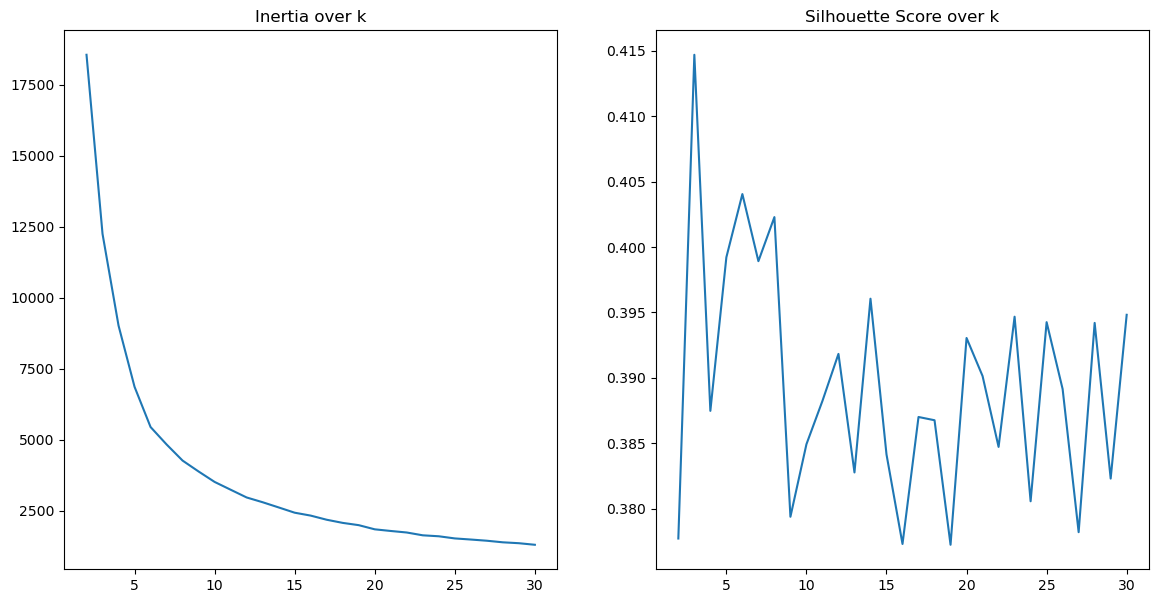

In [19]:
# Plot inertia and silhouette by k to select optimal k
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette)
axes[1].set_title('Silhouette Score over k');

# optimal k=3 

In [20]:
# Convert X_scaled into dataframe with col names
feature_cols = ['Latitude','Longitude','NumMosquitos']
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)


# Create a cluster feature 
km = KMeans(n_clusters=3, random_state=13)
X_train_scaled['cluster'] = km.fit_predict(X_train_scaled)
X_train_scaled.head(10)

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Latitude,Longitude,NumMosquitos,cluster
0,1.007225,-1.047388,-0.734735,1
1,1.007225,-1.047388,-0.734735,1
2,1.364706,-0.718799,-0.734735,1
3,1.179300,-1.294214,-0.734735,1
4,1.179300,-1.294214,-0.548781,1
5,0.713708,0.346629,-0.672750,0
6,0.443325,0.470596,-0.734735,0
7,0.230349,0.473362,-0.734735,0
8,0.230349,0.473362,-0.672750,0
9,0.489131,0.462918,-0.734735,0


In [21]:
# Re-order the NumMosquitos cluster from [0,1,2] to [1,2,3] to be more intuitive
X_train_scaled['cluster'] = X_train_scaled['cluster'].map(lambda x: 1 if x==0 else (2 if x==1 else 3))
X_train_scaled.head(10)

,Latitude,Longitude,NumMosquitos,cluster
0,1.007225,-1.047388,-0.734735,2
1,1.007225,-1.047388,-0.734735,2
2,1.364706,-0.718799,-0.734735,2
3,1.179300,-1.294214,-0.734735,2
4,1.179300,-1.294214,-0.548781,2
5,0.713708,0.346629,-0.672750,1
6,0.443325,0.470596,-0.734735,1
7,0.230349,0.473362,-0.734735,1
8,0.230349,0.473362,-0.672750,1
9,0.489131,0.462918,-0.734735,1


In [22]:
# Check mean NumMosquitos in each of the three clusters

X_inverse = pd.DataFrame(sc.inverse_transform(np.array(X_train_scaled[['Latitude','Longitude','NumMosquitos']])), columns=['Latitude','Longitude','NumMosquitos'])
X_inverse['cluster'] = X_train_scaled['cluster']
X_inverse.groupby('cluster')['NumMosquitos'].mean()

# We can see below that Cluster 3 has the highest average NumMosquitos per trap; Cluster 0 has the lowest average

cluster
1     5.384031
2    11.814787
3    44.262925
Name: NumMosquitos, dtype: float64

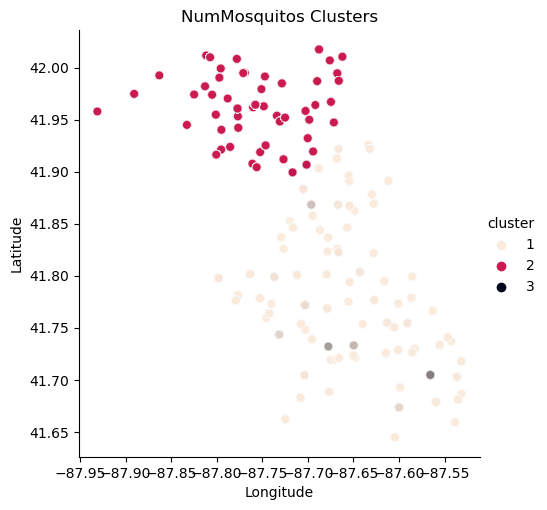

In [23]:
# Visualize the three NumMosquitos clusters (more observations=dark dots)

alphas = np.random.rand(len(train_df))
custom_palette = sns.color_palette("rocket_r", as_cmap=True)
sns.relplot(x='Longitude', y='Latitude', hue='cluster', data=X_inverse, alpha=alphas, s=40, palette=custom_palette)
plt.title('NumMosquitos Clusters');

# cluster  Average NumMosquitos
# 1            5
# 2            12
# 3            44


# NumMosquito tends to be highest in the North of Chicago versus South.
# however, there are nonetheless certain hotpots further South which sees very big NumMosquitos cluster too (see darker spots Cluster 3)

In [24]:
# Create a new feature in train_df to add the NumMosquitos_cluster from X_train_scaled

X_train_scaled.index = train_df.index
train_df['NumMosquitos_cluster'] = X_train_scaled['cluster']
train_df

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,month,year,week,YearWeek,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,NumMosquitos_cluster
Date,,,,,,,,,,,,,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,2007,22,200722,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,2007,22,200722,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,5,2007,22,200722,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,5,2007,22,200722,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,5,2007,22,200722,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-26,"5100 West 72nd Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035__2,"5100 W 72ND ST, Chicago, IL",41.763733,-87.742302,8,6,1,9,2013,39,201339,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
2013-09-26,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.987280,-87.666066,8,5,0,9,2013,39,201339,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
2013-09-26,"1700 North Ashland Avenue, Chicago, IL 60622, USA",CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,"1700 N ASHLAND AVE, Chicago, IL",41.912563,-87.668055,9,1,0,9,2013,39,201339,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


In [25]:
# Fit kNearestNeighbors model to predict the right cluster that indicate NumMosquitos
# Each trap will be sorted into their respective NumMosquitos_cluster by the nearest k=1 neighbor

knn_y = X_train_scaled.pop('cluster')
knn_X = X_train_scaled[['Latitude','Longitude']]
knn = KNeighborsClassifier(n_neighbors=1, weights='distance')
knn.fit(knn_X, knn_y)
knn.score(knn_X, knn_y)

# Reasonably good accuracy of 88% which we will use this kNN model to predict the clusters in test set

0.8822577574719208

In [26]:
# Predict the NumMosquitos clusters for test set according to their geo-coordinates
X_test = test_df[['Latitude','Longitude']]

sc = StandardScaler()
X_test_scaled = sc.fit_transform(X_test)

test_df['NumMosquitos_cluster'] = knn.predict(X_test_scaled)

C:\Users\leagu\anaconda3\envs\datascience\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [27]:
test_df['NumMosquitos_cluster'].value_counts()

1    61795
2    44549
3     9949
Name: NumMosquitos_cluster, dtype: int64

In [28]:
test_df['Trap'].unique()

array(['T002', 'T007', 'T015', 'T045', 'T046', 'T048', 'T049', 'T050',
       'T054', 'T086', 'T091', 'T094', 'T096', 'T129', 'T143', 'T148',
       'T153', 'T159', 'T009', 'T011', 'T016', 'T019', 'T025', 'T028',
       'T031', 'T033', 'T089', 'T090', 'T092', 'T135', 'T141', 'T142',
       'T145', 'T146', 'T147', 'T149', 'T150', 'T151', 'T152', 'T154',
       'T158', 'T162', 'T218', 'T220', 'T001', 'T003', 'T006', 'T008',
       'T012', 'T034', 'T037', 'T040', 'T043', 'T047', 'T051', 'T085',
       'T088', 'T161', 'T219', 'T013', 'T014', 'T018', 'T030', 'T084',
       'T144', 'T160', 'T005', 'T017', 'T044', 'T095', 'T004', 'T035',
       'T036', 'T039', 'T060', 'T061', 'T062', 'T065', 'T066', 'T067',
       'T069', 'T070', 'T071', 'T073', 'T074', 'T075', 'T076', 'T077',
       'T079', 'T080', 'T081', 'T082', 'T083', 'T114', 'T155', 'T063',
       'T115', 'T138', 'T200', 'T206', 'T209', 'T212', 'T215', 'T107',
       'T128', 'T072', 'T078', 'T097', 'T099', 'T100', 'T102', 'T103',
      

# Clustering Traps

All 151 Traps in both train and test sets are clustered into 3 clusters by the historical sum total of WnvPresent of each Trap.  
* Label 1: if count of WnvPresent < 5
* Label 2: if count of WnvPresent < 20
* Label 3: if count of WnvPresent >= 20  

Using the k-NearestNeighbor algorithm, the clusters are first fitted on the 138 Traps in the train set followed by transforming the 13 addititional Traps in the test set based on their proximity to the nearest k=1 neighbor. The assumption is that the closest neighbor is more likely to have similar counts of WnvPresent.

In [29]:
new_traps = list(set(test_df['Trap']) - set(train_df['Trap']))
new_traps

# The additional Traps in test set are all satellite traps except T234!
# Why are the surveillance traps only in the test set?
# Why only these traps have surveillance traps? hotspots?

['T002B',
 'T090A',
 'T200A',
 'T200B',
 'T090B',
 'T002A',
 'T090C',
 'T218C',
 'T218A',
 'T234',
 'T128A',
 'T065A',
 'T218B']

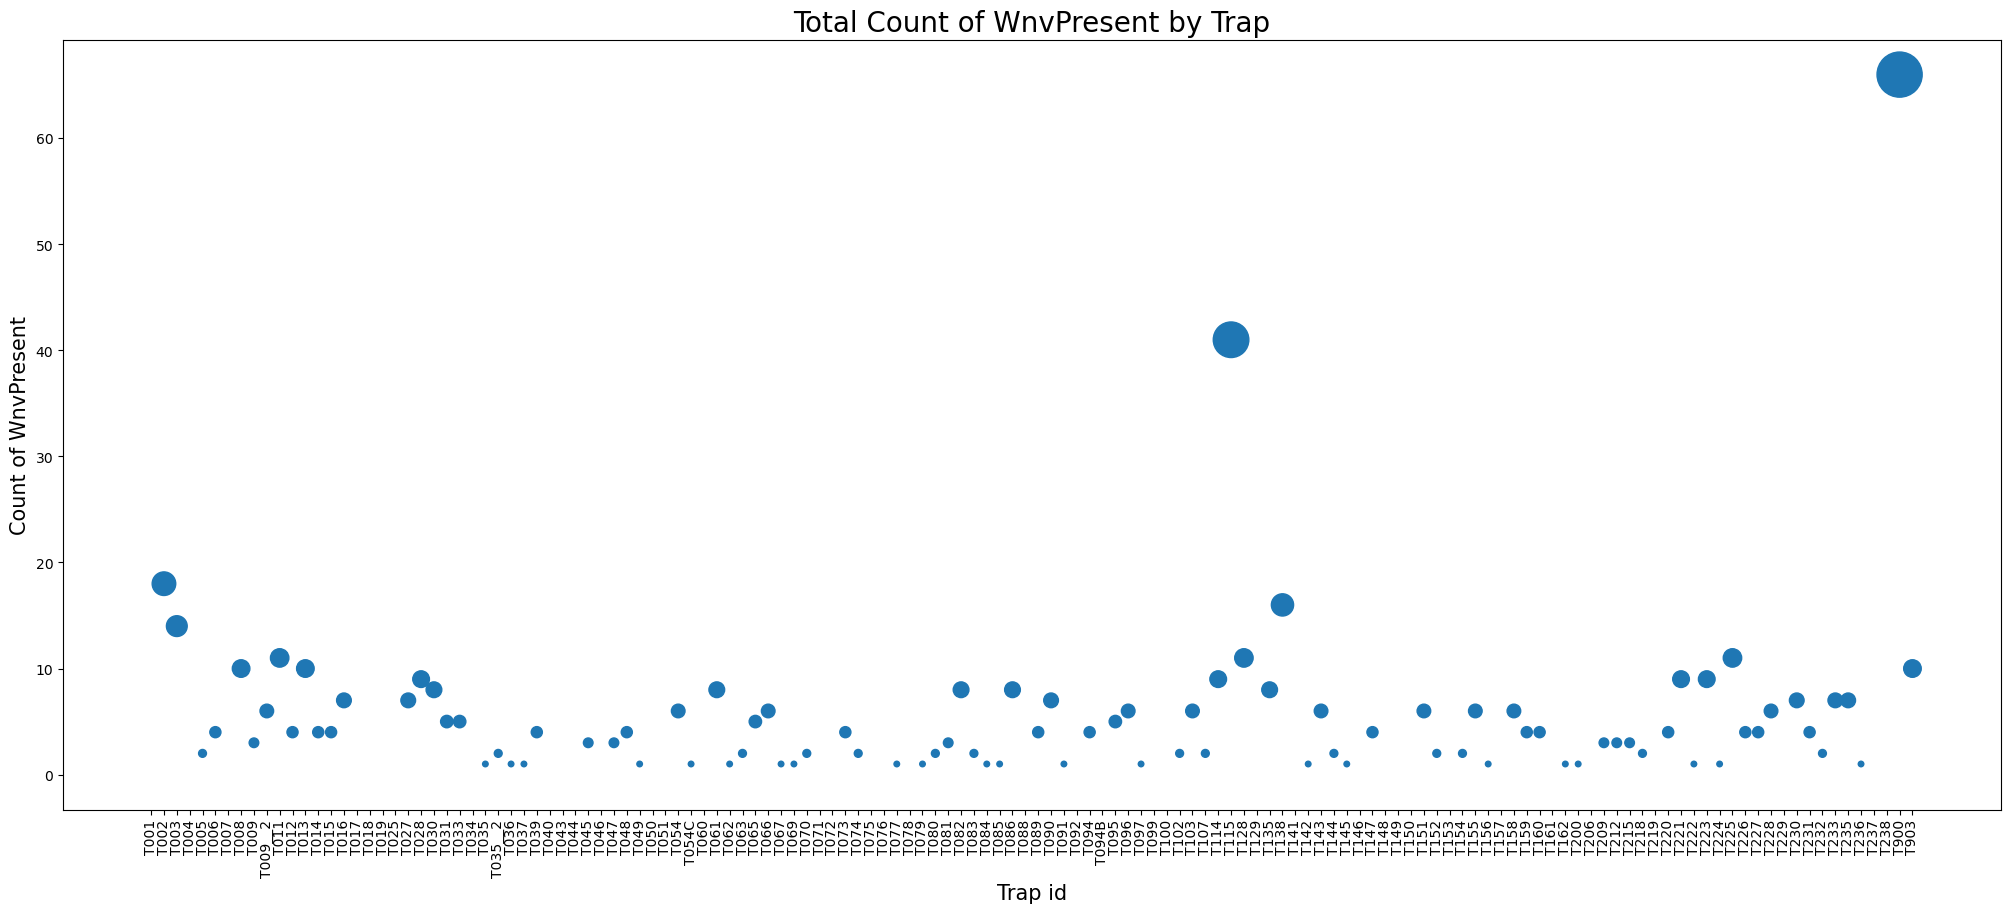

In [30]:
# Total WnvPresent by Traps (bigger dot size=more counts of WnvPresent)

traps_mosquitos = train_df.groupby('Trap')['WnvPresent'].sum().to_frame().reset_index()
plt.figure(figsize=(25,10))
plt.xticks(rotation=90, size=10)
plt.xlabel('Trap id', fontsize=15)
plt.ylabel('Count of WnvPresent', fontsize=15)
plt.title('Total Count of WnvPresent by Trap', fontsize=20)
plt.scatter(x='Trap', y='WnvPresent', s=traps_mosquitos['WnvPresent'].values*16, data=traps_mosquitos);

# Seems that Traps can be clustered into at least 3 tiers by their WnvPresent counts.

In [31]:
# Cluster Traps by their count of WnvPresent into 3 clusters

# Label 1: if count of WnvPresent < 5
# Label 2: if count of WnvPresent < 20
# Label 3: if count of WnvPresent >= 20

traps_mosquitos['Wnv_cluster'] = traps_mosquitos['WnvPresent'].map(lambda x: 1 if x<5 else (2 if x<20 else 3))
traps_mosquitos.head(10)

,Trap,WnvPresent,Wnv_cluster
0,T001,0,1
1,T002,18,2
2,T003,14,2
3,T004,0,1
4,T005,2,1
5,T006,4,1
6,T007,0,1
7,T008,10,2
8,T009,3,1
9,T009__2,6,2


In [32]:
# Add the geocoordinates of each Trap to df
traps_mosquitos['Latitude'] = traps_mosquitos['Trap'].map(lambda x: train_df[train_df['Trap']==x][['Latitude','Longitude']].iloc[0,0])
traps_mosquitos['Longitude'] = traps_mosquitos['Trap'].map(lambda x: train_df[train_df['Trap']==x][['Latitude','Longitude']].iloc[0,1])

In [33]:
traps_mosquitos

,Trap,WnvPresent,Wnv_cluster,Latitude,Longitude
0,T001,0,1,41.953705,-87.733974
1,T002,18,2,41.954690,-87.800991
2,T003,14,2,41.964242,-87.757639
3,T004,0,1,41.962728,-87.748367
4,T005,2,1,41.942114,-87.776385
...,...,...,...,...,...
133,T236,1,1,41.994679,-87.770899
134,T237,0,1,41.738903,-87.695443
135,T238,0,1,41.753391,-87.707394
136,T900,66,3,41.974689,-87.890615


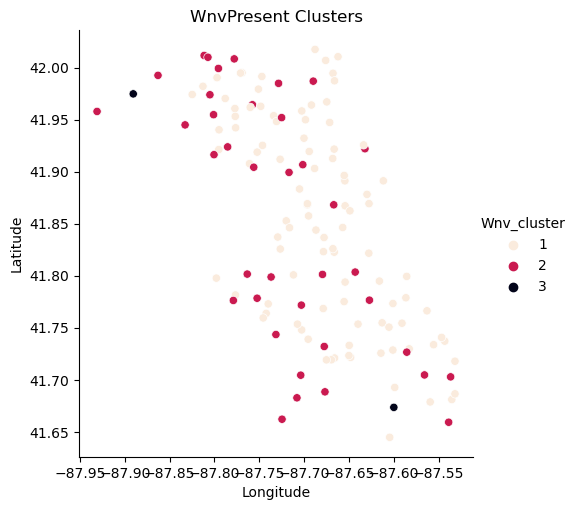

In [34]:
# Plot the geolocation of the Trap clusters (1-least Wnv detected, 3-most Wnv detected)
to_plot = traps_mosquitos[['Latitude','Longitude','Wnv_cluster']]
custom_palette = sns.color_palette("rocket_r", as_cmap=True)
sns.relplot(x='Longitude', y='Latitude', hue='Wnv_cluster', data=to_plot, palette=custom_palette)
plt.title('WnvPresent Clusters');


# Clusters with average count of WnvPresent(cluster 2 spots) are distributed quite evenly across Chicago

In [35]:
# Create dict of all the Traps coordinates for easy retrieval
traps_coordinates = traps_mosquitos[['Trap', 'Latitude','Longitude']].T
traps_coordinates.columns = traps_coordinates.iloc[0]
traps_coordinates = traps_coordinates.iloc[1:].to_dict()

# Add in the geocoordinates of the 13 new Traps from test set into the dict
for trap in new_traps:
    trap_lat = test_df[test_df['Trap']==trap][['Latitude','Longitude']].iloc[0,0]
    trap_long  = test_df[test_df['Trap']==trap][['Latitude','Longitude']].iloc[0,1]
    traps_coordinates[trap] = {'Latitude':trap_lat, 'Longitude':trap_long}

    
traps_coordinates

{'T001': {'Latitude': 41.953705, 'Longitude': -87.733974},
 'T002': {'Latitude': 41.95469, 'Longitude': -87.800991},
 'T003': {'Latitude': 41.964242, 'Longitude': -87.757639},
 'T004': {'Latitude': 41.962728, 'Longitude': -87.748367},
 'T005': {'Latitude': 41.942114, 'Longitude': -87.776385},
 'T006': {'Latitude': 41.990284, 'Longitude': -87.797127},
 'T007': {'Latitude': 41.994991, 'Longitude': -87.769279},
 'T008': {'Latitude': 42.008314, 'Longitude': -87.777921},
 'T009': {'Latitude': 41.981964, 'Longitude': -87.812827},
 'T009__2': {'Latitude': 41.992478, 'Longitude': -87.862995},
 'T011': {'Latitude': 41.944869, 'Longitude': -87.832763},
 'T012': {'Latitude': 41.991429, 'Longitude': -87.747113},
 'T013': {'Latitude': 41.923738, 'Longitude': -87.785288},
 'T014': {'Latitude': 41.970248, 'Longitude': -87.787992},
 'T015': {'Latitude': 41.974089, 'Longitude': -87.824812},
 'T016': {'Latitude': 42.011601, 'Longitude': -87.811506},
 'T017': {'Latitude': 41.960616, 'Longitude': -87.7771

In [36]:
# Create a traps_cluster dict to store the cluster label of each Trap
traps_clusters = traps_mosquitos[['Trap', 'Wnv_cluster']].set_index('Trap')
traps_clusters = traps_clusters['Wnv_cluster'].to_dict()

In [37]:
# Cluster the 13 new Traps in test set into their closest neighbor's cluster label in the train set

from sklearn.neighbors import KNeighborsClassifier

train_wnv_cluster = traps_mosquitos[['Latitude','Longitude']]
train_wnv_cluster = train_wnv_cluster.to_records(index=False).tolist()
y_wnv_cluster = traps_mosquitos['Wnv_cluster']

knn_traps_cluster = KNeighborsClassifier(n_neighbors=1)

knn_traps_cluster.fit(train_wnv_cluster, y_wnv_cluster)

# Test score of training set =1.0 (so model works)
# knn_traps_cluster.score(train_wnv_cluster,y_wnv_cluster)


# Classifying the 13 new Traps here
test_wnv_cluster = []
new_traps_coords = test_df[['Trap', 'Latitude','Longitude']].reset_index()

for trap in new_traps:
    trap_tuple = (traps_coordinates[trap]['Latitude'], traps_coordinates[trap]['Longitude'])
    test_wnv_cluster.append(trap_tuple)
    traps_clusters[trap] = knn_traps_cluster.predict([trap_tuple])[0]


In [38]:
# Check all 151 Trap clusters are here
traps_clusters

{'T001': 1,
 'T002': 2,
 'T003': 2,
 'T004': 1,
 'T005': 1,
 'T006': 1,
 'T007': 1,
 'T008': 2,
 'T009': 1,
 'T009__2': 2,
 'T011': 2,
 'T012': 1,
 'T013': 2,
 'T014': 1,
 'T015': 1,
 'T016': 2,
 'T017': 1,
 'T018': 1,
 'T019': 1,
 'T025': 1,
 'T027': 2,
 'T028': 2,
 'T030': 2,
 'T031': 2,
 'T033': 2,
 'T034': 1,
 'T035': 1,
 'T035__2': 1,
 'T036': 1,
 'T037': 1,
 'T039': 1,
 'T040': 1,
 'T043': 1,
 'T044': 1,
 'T045': 1,
 'T046': 1,
 'T047': 1,
 'T048': 1,
 'T049': 1,
 'T050': 1,
 'T051': 1,
 'T054': 2,
 'T054C': 1,
 'T060': 1,
 'T061': 2,
 'T062': 1,
 'T063': 1,
 'T065': 2,
 'T066': 2,
 'T067': 1,
 'T069': 1,
 'T070': 1,
 'T071': 1,
 'T072': 1,
 'T073': 1,
 'T074': 1,
 'T075': 1,
 'T076': 1,
 'T077': 1,
 'T078': 1,
 'T079': 1,
 'T080': 1,
 'T081': 1,
 'T082': 2,
 'T083': 1,
 'T084': 1,
 'T085': 1,
 'T086': 2,
 'T088': 1,
 'T089': 1,
 'T090': 2,
 'T091': 1,
 'T092': 1,
 'T094': 1,
 'T094B': 1,
 'T095': 2,
 'T096': 2,
 'T097': 1,
 'T099': 1,
 'T100': 1,
 'T102': 1,
 'T103': 2,
 'T107':

In [39]:
# Create new col to classify all the Traps in train and test set to their respective clusters

train_df['trap_cluster'] = train_df['Trap'].map(lambda x: traps_clusters[x])
test_df['trap_cluster'] = test_df['Trap'].map(lambda x: traps_clusters[x])

In [40]:
test_df.to_csv('./datasets/cleaned_test.csv', index=True)
train_df.to_csv('./datasets/cleaned_train.csv', index=True)